In [1]:
import os
import sys 
import gc
import json
import pandas as pd 
import numpy as np 
import talib
import sqlite3 as sql
from itertools import repeat
from p_tqdm import p_map, p_umap, t_map
sys.path.append('../')
from backtester import * 
from fxcmtoken import my_assets

In [2]:
for i, a in enumerate(my_assets): print(i, a)

0 EUR/USD
1 USD/JPY
2 GBP/USD
3 USD/CHF
4 AUD/USD
5 USD/CAD
6 NZD/USD
7 Bund
8 AUS200
9 ESP35
10 EUSTX50
11 FRA40
12 GER30
13 HKG33
14 JPN225
15 NAS100
16 SPX500
17 UK100
18 US30
19 Copper
20 NGAS
21 UKOil
22 USOil
23 XAU/USD
24 XAG/USD


In [3]:
freq = 'H1'
sql_path = f'/home/kachain/python_projects/algorithmic_trading/fxcmpy_trader/PriceData_{freq}.db'
conn = sql.connect(sql_path)
# conn.close()

In [4]:
ticker = my_assets[0]
data_sql = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
for col in ['open', 'close', 'high', 'low']:
    data_sql[col] = data_sql[['bid'+col, 'ask'+col]].mean(axis=1)

In [5]:
params_ranges = {
        'mama': (0.1, 1, 0.1),
        'slope': (10, 101, 10),
        'tsf': (10, 101, 10)
    }

In [6]:
global n_week
n_week = 5

In [7]:
def get_strategy_return(data, signal, param, freq):    
    backtester = IterativeBacktester(data=data, signals=signal, freq=freq)
    backtester.backtest(progress_bar=False)

    return param, backtester.return_df.loc['TotalReturn', 'Portfolio']

def get_optim_param(data, signal, param, freq, start_date, end_date): 
    res = p_umap(get_strategy_return, repeat(data.copy(deep=True)), signal, param, repeat(freq), leave=False)
    optim_param = pd.DataFrame(res).sort_values(by=1, ascending=False).iloc[0,0]
    
    return (start_date, end_date), optim_param

In [8]:
# MAMA

def get_mama_optim(input_data, param_range):

    # mama_range = params_ranges['mama']
    mama_periods = np.arange(param_range[0], param_range[1], param_range[2])

    data = input_data.copy(deep=True)
    data['ht'] = talib.HT_TRENDLINE(data.close)
    data.dropna(axis=0, inplace=True)
    for n in mama_periods:
        data[f"mama_{n:.1f}"], data[f"fama_{n:.1f}"] = talib.MAMA(data.ht, fastlimit=n, slowlimit=n/10)
        data[f'signals_{n:.1f}'] = np.where(data[f"mama_{n:.1f}"] > data[f"fama_{n:.1f}"], 1, -1) 
    data.dropna(axis=0, inplace=True)

    sat_index = data.resample('W-Sat').last().index
    datasets = []
    start_dates = []
    end_dates = []
    params = []
    signals = []

    for i in range(n_week, len(sat_index)-1):
        start_dates.append(sat_index[i])
        end_dates.append(sat_index[i+1])
        data_ = data.loc[sat_index[i-n_week]:sat_index[i],:]
        datasets.append(data_.copy(deep=True))
        sub_params = []
        sub_signals = []
        for n in mama_periods:
            sub_params.append(n)
            sub_signals.append(data_.loc[:,f"signals_{n:.1f}"])
        params.append(sub_params)
        signals.append(sub_signals)
        
    mama_optim = t_map(get_optim_param, datasets, signals, params, repeat(freq), start_dates, end_dates, leave=False)
    mama_optim = pd.DataFrame(mama_optim)
    mama_optim.columns = ['dates', 'mama_param']
    mama_optim.set_index('dates', inplace=True)

    gc.collect()
    
    return mama_optim

In [9]:
# Slope

def get_slope_optim(input_data, param_range):

    # slope_range = params_ranges['slope']
    slope_periods = np.arange(param_range[0], param_range[1], param_range[2])

    data = input_data.copy(deep=True)
    data['ht'] = talib.HT_TRENDLINE(data.close)
    data.dropna(axis=0, inplace=True)
    for n in slope_periods:
        data[f'signals_{n:.0f}'] = talib.LINEARREG_SLOPE(data.ht, timeperiod=n).apply(np.sign)
    data.dropna(axis=0, inplace=True)

    sat_index = data.resample('W-Sat').last().index
    datasets = []
    start_dates = []
    end_dates = []
    params = []
    signals = []

    for i in range(n_week, len(sat_index)-1):
        start_dates.append(sat_index[i])
        end_dates.append(sat_index[i+1])
        data_ = data.loc[sat_index[i-n_week]:sat_index[i],:]
        datasets.append(data_.copy(deep=True))
        sub_params = []
        sub_signals = []
        for n in slope_periods:
            sub_params.append(n)
            sub_signals.append(data_.loc[:,f"signals_{n:.0f}"])
        params.append(sub_params)
        signals.append(sub_signals)
        
    slope_optim = t_map(get_optim_param, datasets, signals, params, repeat(freq), start_dates, end_dates, leave=False)
    slope_optim = pd.DataFrame(slope_optim)
    slope_optim.columns = ['dates', 'slope_param']
    slope_optim.set_index('dates', inplace=True)

    gc.collect()
    
    return slope_optim

In [10]:
# TSF

def get_tsf_optim(input_data, param_range):
    # tsf_range = params_ranges['tsf']
    tsf_periods = np.arange(param_range[0], param_range[1], param_range[2])

    data = input_data.copy(deep=True)
    data['ht'] = talib.HT_TRENDLINE(data.close)
    data.dropna(axis=0, inplace=True)
    for n in tsf_periods:
        data[f'tsf_{n:.0f}'] = talib.TSF(data.ht, n)
        data[f'signals_{n:.0f}'] = np.where(data.ht > data[f'tsf_{n:.0f}'], 1, -1)
    data.dropna(axis=0, inplace=True)

    sat_index = data.resample('W-Sat').last().index
    datasets = []
    start_dates = []
    end_dates = []
    params = []
    signals = []

    for i in range(n_week, len(sat_index)-1):
        start_dates.append(sat_index[i])
        end_dates.append(sat_index[i+1])
        data_ = data.loc[sat_index[i-n_week]:sat_index[i],:]
        datasets.append(data_.copy(deep=True))
        sub_params = []
        sub_signals = []
        for n in tsf_periods:
            sub_params.append(n)
            sub_signals.append(data_.loc[:,f"signals_{n:.0f}"])
        params.append(sub_params)
        signals.append(sub_signals)
        
    tsf_optim = t_map(get_optim_param, datasets, signals, params, repeat(freq), start_dates, end_dates, leave=False)
    tsf_optim = pd.DataFrame(tsf_optim)
    tsf_optim.columns = ['dates', 'tsf_param']
    tsf_optim.set_index('dates', inplace=True)

    gc.collect()
    
    return tsf_optim

In [11]:
mama_optim = get_mama_optim(data_sql ,params_ranges['mama'])
slope_optim = get_slope_optim(data_sql, params_ranges['slope'])
tsf_optim = get_tsf_optim(data_sql, params_ranges['tsf'])

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
best_parameters = pd.DataFrame()
best_parameters = best_parameters.join(mama_optim, how='outer')
best_parameters = best_parameters.join(slope_optim, how='outer')
best_parameters = best_parameters.join(tsf_optim, how='outer')

In [13]:
best_parameters

,mama_param,slope_param,tsf_param
dates,,,
"(2021-03-06 00:00:00, 2021-03-13 00:00:00)",0.4,NaN,NaN
"(2021-03-13 00:00:00, 2021-03-20 00:00:00)",0.4,20.0,80.0
"(2021-03-20 00:00:00, 2021-03-27 00:00:00)",0.4,30.0,40.0
"(2021-03-27 00:00:00, 2021-04-03 00:00:00)",0.4,30.0,80.0
"(2021-04-03 00:00:00, 2021-04-10 00:00:00)",0.1,100.0,40.0
...,...,...,...
"(2022-07-16 00:00:00, 2022-07-23 00:00:00)",0.1,50.0,10.0
"(2022-07-23 00:00:00, 2022-07-30 00:00:00)",0.2,40.0,10.0
"(2022-07-30 00:00:00, 2022-08-06 00:00:00)",0.3,40.0,10.0


In [14]:
best_parameters.dropna(axis=0, inplace=True)
best_parameters['params'] = best_parameters.values.tolist()
dates = best_parameters.index.values
parameters = best_parameters.params.values

In [15]:
# params --> (mama, slope, tsf)
# params.apply(func) --> get returns

def get_aggregate_return(data, ds, params):
    data_ = data.loc[:ds[1],:].copy(deep=True)
    data_['ht'] = talib.HT_TRENDLINE(data_.close)

    data_["mama"], data_["fama"] = talib.MAMA(data_.ht, fastlimit=params[0], slowlimit=params[0]/10)
    data_['signals_mama'] = np.where(data_[f"mama"] > data_["fama"], 1, -1) 

    data_['signals_slope'] = talib.LINEARREG_SLOPE(data_.ht, timeperiod=params[1]).apply(np.sign)

    data_['tsf'] = talib.TSF(data_.ht, params[2])
    data_['signals_tsf'] = np.where(data_.ht > data_['tsf'], 1, -1)
    
    data_.dropna(axis=0, inplace=True)
    data_ = data_.loc[ds[0]:ds[1],:]
    data_['signals_aggregate'] = data_[['signals_mama', 'signals_slope', 'signals_tsf']].mode(axis=1)
    
    backtester = IterativeBacktester(data=data_, signals=data_.signals_aggregate, freq=freq)
    backtester.backtest(progress_bar=False)
    
    return ds[0], backtester.return_df.loc['TotalReturn', 'Portfolio']


In [17]:
res_ = p_umap(get_aggregate_return, repeat(data_sql.copy(deep=True)), dates, parameters)

  0%|          | 0/76 [00:00<?, ?it/s]

In [18]:
res_df = pd.DataFrame(res_)
res_df.columns = ['dates', ticker]
res_df.set_index('dates', inplace=True)

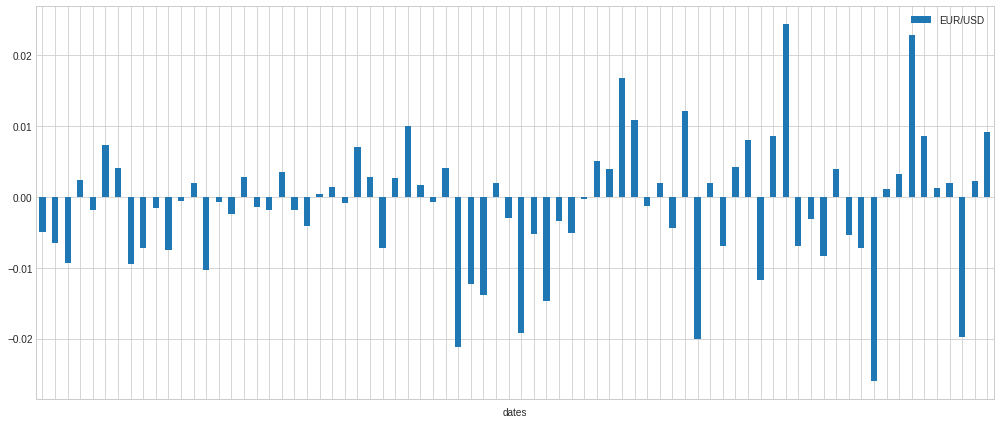

In [21]:
ax = res_df.plot(kind='bar', figsize=(14,6))
ax.set_xticklabels('')
plt.tight_layout()
plt.show()

In [23]:
res_df.apply(np.sign).value_counts(normalize=True)

EUR/USD
-1.0       0.539474
 1.0       0.460526
dtype: float64

In [45]:
def get_backtest_returns(ticker, freq, params_ranges):
    freq = 'H1'
    sql_path = f'/home/kachain/python_projects/algorithmic_trading/fxcmpy_trader/PriceData_{freq}.db'
    conn = sql.connect(sql_path)
    data_sql = pd.read_sql(f"SELECT * FROM '{ticker}'", conn, parse_dates=['date'], index_col=['date'])
    for col in ['open', 'close', 'high', 'low']:
        data_sql[col] = data_sql[['bid'+col, 'ask'+col]].mean(axis=1)
    conn.close()
        
    mama_optim = get_mama_optim(data_sql ,params_ranges['mama'])
    slope_optim = get_slope_optim(data_sql, params_ranges['slope'])
    tsf_optim = get_tsf_optim(data_sql, params_ranges['tsf'])
    
    best_parameters = pd.DataFrame()
    best_parameters = best_parameters.join(mama_optim, how='outer')
    best_parameters = best_parameters.join(slope_optim, how='outer')
    best_parameters = best_parameters.join(tsf_optim, how='outer')
    
    param_list = best_parameters[['mama_param', 'slope_param', 'tsf_param']].values.tolist()
    best_parameters['params'] = param_list
    best_parameters_shift = best_parameters.shift(1).dropna(axis=0)['params'].copy(deep=True)
    
    dates = best_parameters_shift.index.values
    parameters = best_parameters_shift.values
    
    res_ = p_umap(get_aggregate_return, repeat(data_sql.copy(deep=True)), dates, parameters, leave=False)
    res_df = pd.DataFrame(res_)
    res_df.columns = ['dates', ticker]
    res_df.set_index('dates', inplace=True)
    
    gc.collect()
    
    return res_df

In [46]:
ret_ = t_map(get_backtest_returns, my_assets, repeat(freq), repeat(params_ranges))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Process ForkPoolWorker-2049:
Process ForkPoolWorker-2054:
Process ForkPoolWorker-2056:
Process ForkPoolWorker-2053:
Process ForkPoolWorker-2050:
Process ForkPoolWorker-2051:
Process ForkPoolWorker-2052:
Process ForkPoolWorker-2055:
Traceback (most recent call last):
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kachain/anaconda3/envs/

KeyboardInterrupt: 

  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/pandas/core/series.py", line 2757, in _construct_result
    out = self._constructor(result, index=self.index)
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/pandas/core/construction.py", line 428, in sanitize_array
    subarr = _try_cast(data, dtype, copy, raise_cast_failure)
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
  File "/home/kachain/anaconda3/envs/DL/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/tmp/ipykernel_432145/2871908218.py", 

In [122]:
backtest_results = pd.DataFrame()

for frame in ret_:
    backtest_results = backtest_results.join(frame, how='outer')
    
backtest_results.sort_index(ascending=True, inplace=True)

In [125]:
save_folder = 'backtest_parameters'
os.makedirs(save_folder, exist_ok=True)
backtest_results.to_csv(os.path.join(save_folder, 'backtest_params_results.csv'))